# CH1 MIRI/JWST
## JWST/MIRI Spectral Analysis Script

Aperture radius: 0.5" = 3.85 pixels


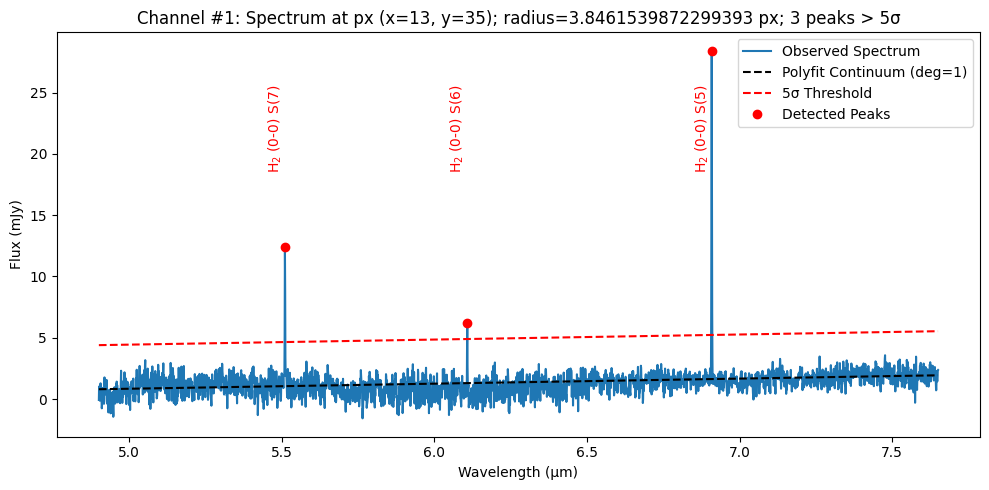

Detected Peak Wavelengths (μm):
[5.51   6.1076 6.9084]
Detected peaks (wavelength ([μm]), flux (mJy)):
5.5100 μm	12.4
6.1076 μm	6.181
6.9084 μm	28.41


In [1]:
#CH1
import numpy as np
import matplotlib.pyplot as plt
from spectral_cube import SpectralCube
from astropy import units as u
from scipy.signal import find_peaks
from tqdm import tqdm
import os 
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

output_dir = "moment_maps_per_peak"
os.makedirs(output_dir, exist_ok=True)

# Define dictionary: wavelength (Å) -> label
lines = {
    5.5100: 'H$_2$ (0-0) S(7)',
    6.1076: 'H$_2$ (0-0) S(6)',
    6.9084: 'H$_2$ (0-0) S(5)',
}



# --- Step 1: Load JWST cube ---####################################
#Change only /path-to-data-directory  and file name (i.e. file_dir) hare.
# data_dir = '/path-to-data-directory/'
# file_dir = '*****_miri_ch1-****' #your JWST IFU file name, without adding "_s3d.fits"
data_dir = '/Users/somnathdutta/Desktop/outflow_analysis/JWST/Data/MAST_2024-09-18T0222/JWST/'
file_dir = 'jw01854-c1007_t002_miri_ch1-shortmediumlong' #Change this Only
file_fits = '/'+file_dir+'_s3d.fits'
fitsfile = data_dir+file_dir+file_fits

#fits.info(fitsfile) # 1  SCI           1 ImageHDU        89   (43, 51, 3438)   float32   
cube = SpectralCube.read(fitsfile, hdu='SCI').with_spectral_unit(u.micron)
#cube = cube.to(u.Jy)
#flux_unit = cube.unit.to_string()  # e.g., 'Jy / beam' or 'MJy / sr'


# --- Convert MJy/sr to μJy/pixel ---
# pixel_scale_arcsec = 0.11#96  # Adjust if needed based on the channels
# pixel_area_sr = ((pixel_scale_arcsec * u.arcsec) ** 2).to(u.sr)

# Get pixel area in steradians from SpectralCube's WCS
pixel_area_sr = cube.wcs.proj_plane_pixel_area()  # returns an astropy Quantity in steradians

cube = cube.to(u.MJy/u.sr)   # Standardize unit
cube = cube * pixel_area_sr  # Convert to MJy
cube = cube.to(u.mJy)        # Final unit: mJy
cube_next = cube

flux_unit = cube.unit.to_string()  # Will now be 'mJy'


wavelengths = cube.spectral_axis.to(u.micron).value  # shape: (N_lambda,)
ny, nx = cube.shape[1:]

#--- Step 2: Circular mask ---#####################################
# -Define central pixel of sptrum extraction and  radius-
x0, y0 = 13, 35   # central pixel of spectrum extraction
#radius = 3       # aperture radius in pixels, comment if using arcsec-based radius


# Compute pixel scale and aperture radius in pixels, 
#commen this section if you are using pixel-based radius as indicated above
pixel_scales = proj_plane_pixel_scales(cube.wcs.celestial)  # degrees/pixel
pixel_scale_arcsec = pixel_scales[0] * 3600  # arcsec/pixel (assuming square pixels)
aperture_radius_arcsec = 0.5 #arcsec
radius_pix_aperture = aperture_radius_arcsec / pixel_scale_arcsec
print(f"Aperture radius: {aperture_radius_arcsec}\" = {radius_pix_aperture:.2f} pixels")
radius = radius_pix_aperture

## Use below section to varify or any error in above section
# aperture_radius_arcsec = 0.2  # aperture radius in arcseconds
# # === Extract spaxel size from WCS ===
# wcs = WCS(cube.header)
# cdelt1 = np.abs(wcs.wcs.cdelt[1]) * 3600  # RA spaxel size in arcsec
# cdelt2 = np.abs(wcs.wcs.cdelt[2]) * 3600  # Dec spaxel size in arcsec
# mean_spaxel_size = (cdelt1 + cdelt2) / 2.0
# radius = aperture_radius_arcsec / mean_spaxel_size #in pixel
# print(f"Using aperture radius: {aperture_radius_arcsec}″ → {radius_pix:.2f} pixels")


yy, xx = np.mgrid[0:ny, 0:nx]
mask = (xx - x0)**2 + (yy - y0)**2 <= radius**2
########


# #######

# --- Step 3: Extract summed spectrum within aperture ---
data = cube.unmasked_data[:, mask]  # shape: (N_lambda, N_pixels)
spectrum = np.nansum(cube._data[:, mask], axis=1)  # _data is a Quantity array

# --- Step 4: Define continuum-fitting regions (line-free) ---
continuum_windows = [(4.8, 5.2), (7.5, 8.0)]  # micron; adjust based on your data

# Create boolean mask to select continuum regions
cont_mask = np.zeros_like(wavelengths, dtype=bool)
for wmin, wmax in continuum_windows:
    cont_mask |= (wavelengths >= wmin) & (wavelengths <= wmax)

# Extract continuum points
wave_cont = wavelengths[cont_mask]
flux_cont = spectrum[cont_mask]

# --- Step 5: Polynomial fit to continuum ---
degree = 1  # linear fit; use 2 for quadratic if needed
coeffs = np.polyfit(wave_cont, flux_cont, deg=degree)
continuum_fit = np.polyval(coeffs, wavelengths)

# --- Step 6: Estimate noise and detect peaks ---
residuals = spectrum - continuum_fit
noise = np.nanstd(residuals[cont_mask])  # sigma from continuum regions
sigma_given = 5
threshold = continuum_fit + sigma_given * noise

peaks, properties = find_peaks(spectrum, height=threshold)

# --- Step 7: Plot ---
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, spectrum, label='Observed Spectrum')
plt.plot(wavelengths, continuum_fit, 'k--', label=f'Polyfit Continuum (deg={degree})')
#plt.axhline(continuum_fit.mean() + 5 * noise, color='red', linestyle='--', label='10σ Threshold')
plt.plot(wavelengths, continuum_fit + sigma_given * noise, 'r--', label=f'{sigma_given}σ Threshold')
plt.plot(wavelengths[peaks], spectrum[peaks], 'ro', label='Detected Peaks')

#######
# Annotate using the dictionary
for wave, label in lines.items():
    #plt.axvline(wave, color='red', linestyle='--', alpha=0.5)
    plt.text(wave - 0.06, max(spectrum)*0.65, label, rotation=90, verticalalignment='bottom', color='red')

##########

plt.xlabel('Wavelength (μm)')
#plt.ylabel('Flux')
plt.ylabel(f'Flux ({flux_unit})')
plt.title(f'Channel #1: Spectrum at px (x={x0}, y={y0}); radius={radius} px; {len(peaks)} peaks > {sigma_given}σ')
#plt.title(f'Channel #1: Spectrum at px (x={x0}, y={y0}); radius={aperture_radius_arcsec} arcsec; {len(peaks)} peaks > {sigma_given}σ')
plt.legend()
plt.tight_layout()
plt.savefig(f"{output_dir}/full_spectra__{file_dir}.png", dpi=200)
plt.show()

# --- Optional: Print peak info ---
print("Detected Peak Wavelengths (μm):")
print(np.round(wavelengths[peaks], 4))
detected_peaks_wavelengths = wavelengths[peaks]

# --- Print peak results ---
#print(f"\nσ estimated from continuum: {sigma:.4g}")
print(f"Detected peaks (wavelength ([μm]), flux ({flux_unit})):")
for wl, flux in zip(wavelengths[peaks], spectrum[peaks]):
    print(f"{wl:.4f} μm\t{flux:.4g}")
#CH1    

## JWST MIRI Channel Moment Map Generator (per Emission Line)

Integrated flux (actual spectrum) at peak 5.5100 μm over 4 channels >3σ: 2.408e-02 [mJy·μm]
Continuum-subtracted integrated flux at 5.5100 μm: 2.063e-02 [mJy·μm]
Peak flux (continuum-subtracted) at 5.5100 μm: 1.132e+01 [mJy]
Peak 1 at 5.5100 μm: 4 channels > 3σ
Channels (μm): [5.50920008 5.51000008 5.51080008 5.51160008]
Channel widths (μm): [0.0008 0.0008 0.0008]


Peak 1/3: 100%|████████████████████████████████████████| 51/51 [00:09<00:00,  5.41it/s]


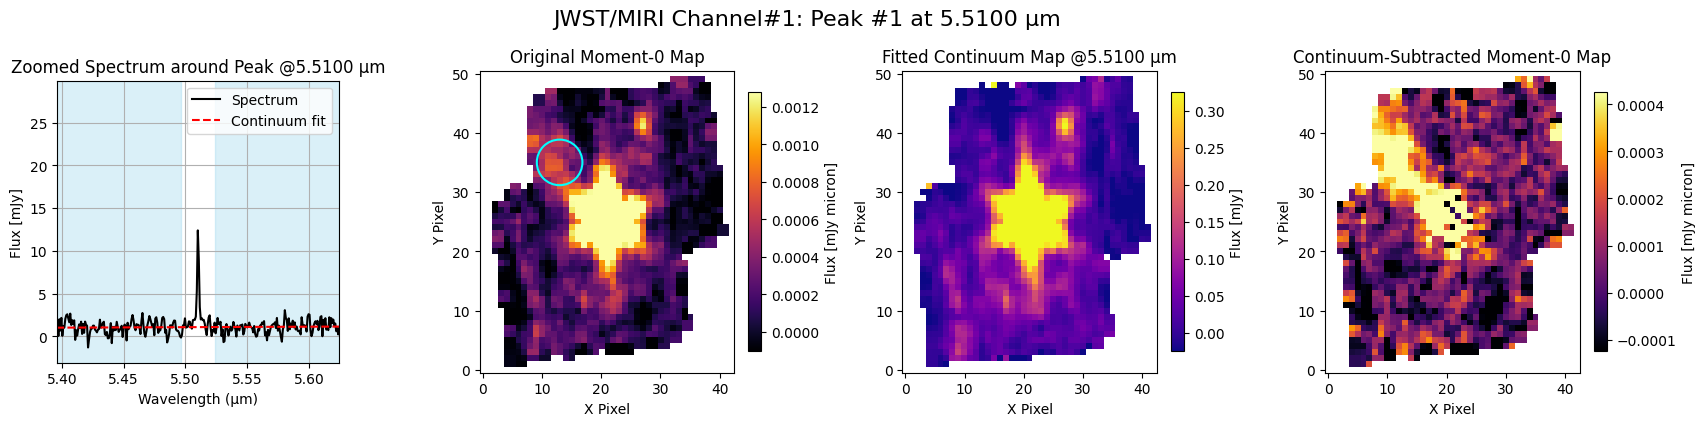

Integrated flux (actual spectrum) at peak 6.1076 μm over 2 channels >3σ: 8.425e-03 [mJy·μm]
Continuum-subtracted integrated flux at 6.1076 μm: 7.204e-03 [mJy·μm]
Peak flux (continuum-subtracted) at 6.1076 μm: 5.418e+00 [mJy]
Peak 2 at 6.1076 μm: 2 channels > 3σ
Channels (μm): [6.10680006 6.10760006]
Channel widths (μm): [0.0008]


Peak 2/3: 100%|████████████████████████████████████████| 51/51 [00:07<00:00,  6.48it/s]


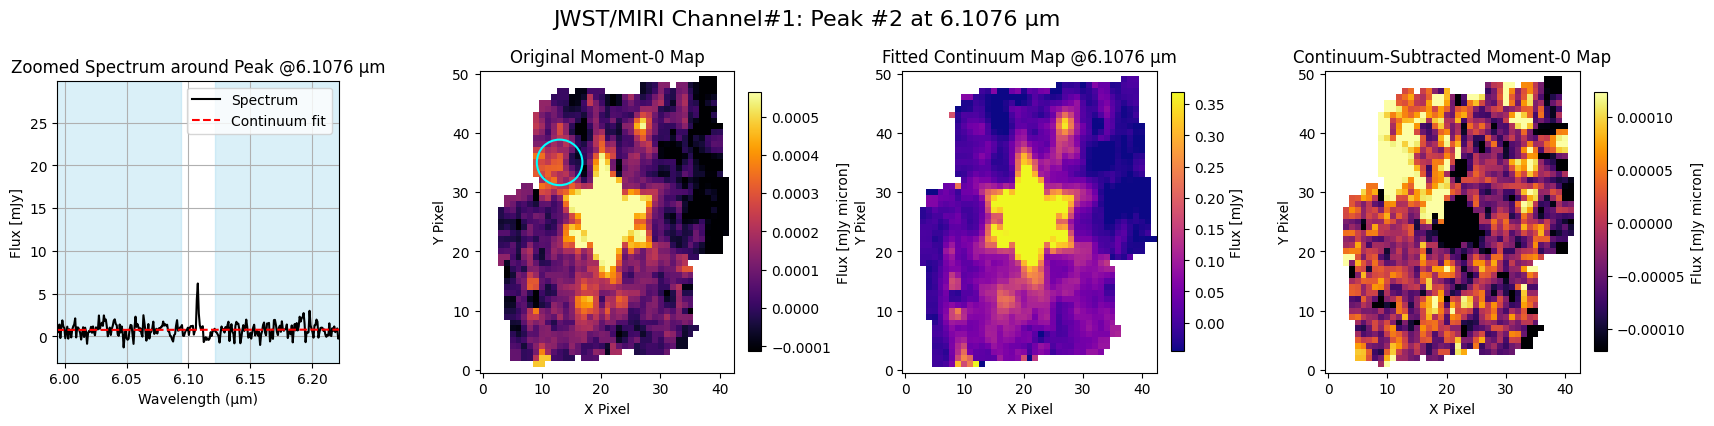

Integrated flux (actual spectrum) at peak 6.9084 μm over 6 channels >3σ: 6.688e-02 [mJy·μm]
Continuum-subtracted integrated flux at 6.9084 μm: 5.992e-02 [mJy·μm]
Peak flux (continuum-subtracted) at 6.9084 μm: 2.696e+01 [mJy]
Peak 3 at 6.9084 μm: 6 channels > 3σ
Channels (μm): [6.90680004 6.90760004 6.90840004 6.90920004 6.91000004 6.91080004]
Channel widths (μm): [0.0008 0.0008 0.0008 0.0008 0.0008]


Peak 3/3: 100%|████████████████████████████████████████| 51/51 [00:07<00:00,  6.90it/s]


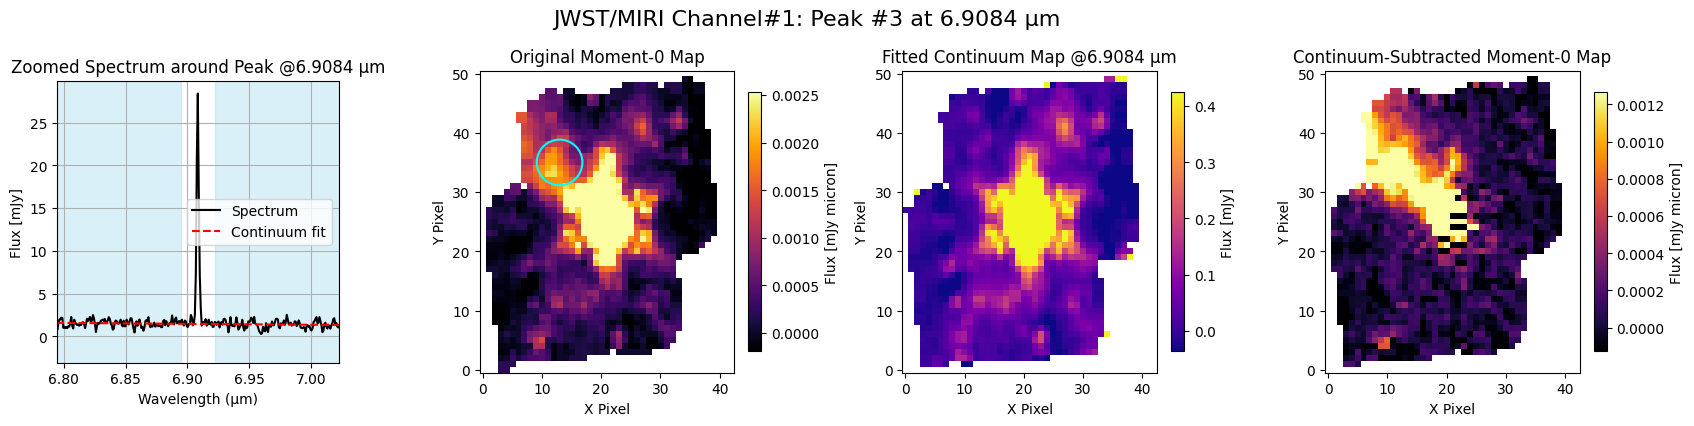

✅ Done: CH1 Moment maps generated for all detected peaks.


In [2]:
#CH1
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from spectral_cube import SpectralCube
from astropy.visualization import simple_norm
from tqdm import tqdm
from matplotlib.patches import Circle


# --- Load the JWST cube --- 
#Comment this section, since this cell#2 will take input from the output of above cell#1
# fitsfile = '.....'
# cube = SpectralCube.read(fitsfile, hdu='SCI').with_spectral_unit(u.micron)

# detected_peaks_wavelengths = [...]  # your detected peak wavelengths in microns
# x0, y0 = ...  # aperture center pixel coordinates
# radius = ...  # aperture radius in pixels
# output_dir = 'output_directory_path'
# flux_unit = cube.unit  # or specify flux unit string

delta1 = 0.1  # micron; continuum window half-width, adjust if needed
gap1 = 0.014  # micron; gap between line and continuum windows, adjust if needed. 

for i, peak in enumerate(detected_peaks_wavelengths):
    wavelengths = cube.spectral_axis.to(u.micron).value
    ny, nx = cube.shape[1:]
    
    # Circular mask for aperture
    yy, xx = np.mgrid[0:ny, 0:nx]
    mask = (xx - x0)**2 + (yy - y0)**2 <= radius**2
    
    # Extract summed spectrum within aperture
    spectrum = np.nansum(cube._data[:, mask], axis=1)
    
    # Define continuum windows
    cont_windows = [
        (peak - delta1 - gap1, peak - gap1),
        (peak + gap1, peak + delta1 + gap1)
    ]
    
    # Continuum mask for fitting
    cont_mask = np.zeros_like(wavelengths, dtype=bool)
    for wmin, wmax in cont_windows:
        cont_mask |= (wavelengths >= wmin) & (wavelengths <= wmax)
    wave_cont = wavelengths[cont_mask]
    flux_cont = spectrum[cont_mask]
    
    if len(wave_cont) < 2:
        print(f"Not enough continuum points around peak {peak:.6f} μm for fit. Skipping...")
        continue
    
    # Fit continuum to full spectrum for residual calculation
    coeffs = np.polyfit(wave_cont, flux_cont, deg=1)
    continuum_fit = np.polyval(coeffs, wavelengths)
    
    # Residual spectrum
    residual_spectrum = spectrum - continuum_fit
    
    # Estimate noise sigma from continuum residuals
    residual_continuum = residual_spectrum[cont_mask]
    noise_sigma = np.nanstd(residual_continuum)
    
    # Define spectral slab including peak and continuum windows
    lambda_min = (peak - delta1 - gap1) * u.micron
    lambda_max = (peak + delta1 + gap1) * u.micron
    cube2 = cube.spectral_slab(lambda_min, lambda_max)
    wavelengths2 = cube2.spectral_axis.to(u.micron).value
    
    # Sum spectrum in aperture from cube2
    spectrum2 = np.nansum(cube2._data[:, mask], axis=1)
    
    # Residual spectrum in cube2 range
    continuum_fit2 = np.polyval(coeffs, wavelengths2)
    residual_spectrum2 = spectrum2 - continuum_fit2
    
    # Select channels with residual > 3 sigma
    significant_channels = np.where(residual_spectrum2 > 3 * noise_sigma)[0]
    
    #############
    # Integrated flux from actual spectrum (not continuum-subtracted), in aperture, for channels > 3 sigma
    delta_lambda = np.mean(np.diff(wavelengths2))  # micron per channel
    num_sig_channels = len(significant_channels)

    if num_sig_channels > 0:
        integrated_flux = 0.0
        for ch in significant_channels:
            # sum flux in aperture at this channel
            flux_ch = np.nansum(cube2._data[ch, mask])
            integrated_flux += flux_ch * delta_lambda  # flux * wavelength channel width (μm)
        
        print(f"Integrated flux (actual spectrum) at peak {peak:.4f} μm over {num_sig_channels} channels >3σ: {integrated_flux:.3e} [{flux_unit}·μm]")
    else:
        print(f"No >3σ channels at peak {peak:.4f} μm for integrated flux calculation.")
    ##########
    
    ###########
    # Integrate the residual spectrum in μm units for channels above 3σ
    delta_lambda = np.mean(np.diff(wavelengths2))  # average spectral resolution in μm
    flux_contsub = np.sum(residual_spectrum2[significant_channels]) * delta_lambda
    print(f"Continuum-subtracted integrated flux at {peak:.4f} μm: {flux_contsub:.3e} [{flux_unit}·μm]")
    # Get peak residual flux at the channel closest to the line center (peak)
    peak_idx = np.argmin(np.abs(wavelengths2 - peak))
    peak_flux_subtracted = residual_spectrum2[peak_idx]
    print(f"Peak flux (continuum-subtracted) at {peak:.4f} μm: {peak_flux_subtracted:.3e} [{flux_unit}]")
    #############
 
    # Print channels and channel widths above 3 sigma
    channels_wavelengths = wavelengths2[significant_channels]
    if len(significant_channels) > 1:
        channel_widths = np.diff(wavelengths2)  # differences between channels
        selected_channel_widths = channel_widths[significant_channels[:-1]]
    else:
        selected_channel_widths = np.array([])
    
    print(f"Peak {i+1} at {peak:.4f} μm: {len(significant_channels)} channels > 3σ")
    print("Channels (μm):", channels_wavelengths)
    if len(selected_channel_widths) > 0:
        print("Channel widths (μm):", selected_channel_widths)
    else:
        print("Channel widths (μm): N/A (only one significant channel)")
    
    if len(significant_channels) == 0:
        print(f"No channels above 3σ for peak {peak:.4f} μm, skipping moment maps.")
        continue
    
    # Build continuum-subtracted cube for full cube2 spectral range
    n_lambda, ny, nx = cube2.shape
    contsub_cube = np.full((n_lambda, ny, nx), np.nan)
    continuum_map = np.full((ny, nx), np.nan)
    
    # Pixel-wise continuum fitting for cube2 wavelengths
    valid_idx = np.where(cont_mask)[0]
    for y in tqdm(range(ny), desc=f"Peak {i+1}/{len(detected_peaks_wavelengths)}"):
        for x in range(nx):
            spec = cube2[:, y, x].value
            if np.all(np.isnan(spec)):
                continue
            # Use continuum indices relative to cube2 spectral axis
            cont_mask_cube2 = np.zeros_like(wavelengths2, dtype=bool)
            for wmin, wmax in cont_windows:
                cont_mask_cube2 |= (wavelengths2 >= wmin) & (wavelengths2 <= wmax)
            spec_cont = spec[cont_mask_cube2]
            valid = ~np.isnan(spec_cont)
            if np.sum(valid) < 2:
                continue
            coeffs_pix = np.polyfit(wavelengths2[cont_mask_cube2][valid], spec_cont[valid], deg=1)
            fitted_full = np.polyval(coeffs_pix, wavelengths2)
            contsub_cube[:, y, x] = spec - fitted_full
            continuum_map[y, x] = np.polyval(coeffs_pix, peak)
    
    cube_sub = SpectralCube(data=contsub_cube * cube.unit, wcs=cube2.wcs).with_spectral_unit(u.micron)
    
    # Compute moment maps from only channels above 3 sigma
    contsub_mask = np.zeros(n_lambda, dtype=bool)
    contsub_mask[significant_channels] = True
    if np.sum(contsub_mask) < 1:
        print(f"No channels above 3 sigma for peak {peak:.4f} μm after selection. Skipping moment maps.")
        continue
    
    moment0_orig = cube2.spectral_slab(wavelengths2[significant_channels[0]]*u.micron,
                                      wavelengths2[significant_channels[-1]]*u.micron).moment(order=0)
    moment0_sub = cube_sub.spectral_slab(wavelengths2[significant_channels[0]]*u.micron,
                                        wavelengths2[significant_channels[-1]]*u.micron).moment(order=0)
    
    # Plotting
    fig, axs = plt.subplots(1, 4, figsize=(20, 5), gridspec_kw={'wspace': 0.5})
    fig.suptitle(f"JWST/MIRI Channel#1: Peak #{i+1} at {peak:.4f} µm", fontsize=16, y=0.92)
    
    

    # Panel 1: Zoomed spectrum with continuum fit and windows
    axs[0].plot(wavelengths, spectrum, color='black', label='Spectrum')
    axs[0].plot(wavelengths, continuum_fit, 'r--', label='Continuum fit')
    for wmin, wmax in cont_windows:
        axs[0].axvspan(wmin, wmax, color='skyblue', alpha=0.3)
    axs[0].set_xlim(cont_windows[0][0], cont_windows[1][1])
    axs[0].set_xlabel('Wavelength (μm)')
    axs[0].set_ylabel(f'Flux [{flux_unit}]')
    axs[0].set_title(f'Zoomed Spectrum around Peak @{peak:.4f} μm')
    axs[0].legend()
    axs[0].grid(True)
    axs[0].set_aspect(aspect=1.0 / axs[0].get_data_ratio())
    
    # Panel 2: Original Moment-0 Map
    norm0 = simple_norm(moment0_orig.value, 'linear', percent=85)
    im0 = axs[1].imshow(moment0_orig.value, origin='lower', cmap='inferno', norm=norm0)
    axs[1].set_title('Original Moment-0 Map')
    axs[1].set_xlabel('X Pixel')
    axs[1].set_ylabel('Y Pixel')
    cbar0 = plt.colorbar(im0, ax=axs[1], fraction=0.046)
    cbar0.set_label(f'Flux [{moment0_orig.unit}]')
    # Add a circle
    circle = Circle((x0, y0), radius, edgecolor='cyan', facecolor='none',
                lw=1.5, transform=axs[1].transData, zorder=99)
    axs[1].add_patch(circle)
    ######
    
    # Panel 3: Fitted Continuum Map
    norm1 = simple_norm(continuum_map, 'linear', percent=85)
    im1 = axs[2].imshow(continuum_map, origin='lower', cmap='plasma', norm=norm1)
    axs[2].set_title(f'Fitted Continuum Map @{peak:.4f} µm')
    axs[2].set_xlabel('X Pixel')
    axs[2].set_ylabel('Y Pixel')
    cbar1 = plt.colorbar(im1, ax=axs[2], fraction=0.046)
    cbar1.set_label(f'Flux [{cube2.unit}]')
    
    # Panel 4: Continuum-Subtracted Moment-0 Map
    norm2 = simple_norm(moment0_sub.value, 'linear', percent=85)
    im2 = axs[3].imshow(moment0_sub.value, origin='lower', cmap='inferno', norm=norm2)
    axs[3].set_title('Continuum-Subtracted Moment-0 Map')
    axs[3].set_xlabel('X Pixel')
    axs[3].set_ylabel('Y Pixel')
    cbar2 = plt.colorbar(im2, ax=axs[3], fraction=0.046)
    cbar2.set_label(f'Flux [{moment0_sub.unit}]')
    
    plt.savefig(f"{output_dir}/moment_maps_peak_{i+1}_{peak:.4f}.png", dpi=200, bbox_inches='tight')
    plt.show()
    plt.close()
    
    # Save FITS files
    header = cube_sub.wcs.celestial.to_header()
    fits.writeto(f"{output_dir}/moment0_original_{peak:.4f}.fits", moment0_orig.value, header, overwrite=True)
    fits.writeto(f"{output_dir}/continuum_map_{peak:.4f}.fits", continuum_map, header, overwrite=True)
    fits.writeto(f"{output_dir}/moment0_subtracted_{peak:.4f}.fits", moment0_sub.value, header, overwrite=True)

print("✅ Done: CH1 Moment maps generated for all detected peaks.")
